In [1]:
import pandas as pd
import os
import numpy as np
import numpy.ma as ma 
import awkward as ak
from tqdm import tqdm
import torch
import torch_geometric as tg
import torch_geometric
from torch_geometric.data import Data   
#import torch
from torch_geometric.data import InMemoryDataset, download_url 
import torch_geometric.transforms as T 
 
#NOTE: NEW 2/20/23  
from typing import List, Union

from torch_geometric.data import Data, HeteroData
from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform  

In [2]:
torch.cuda.empty_cache()

#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_x_cx_recmomfull_20000' not horrible, ksate around .2
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_x_cx_recfull_vertmom_20000' #much better, bad peak and dip though, so if can fix that, p value
#.09, KstestResult(statistic=0.09777468706536856, pvalue=2.779826736292836e-60)
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_onlymomentum_rec_20000' shit
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_mommnetumvertx_rec_20000'
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_all_rec_20000'#not bad, need to do rec stuff though
#root = '/hpc/group/vossenlab/kam264/mom_magnitude_pi_all_protmom_20000' #same as above, but got it printed. but rec is jsut z part. 
#root = '/hpc/group/vossenlab/kam264/stupid_idea' #same as above, but got it printed. but rec is jsut z part. 
#root = '/hpc/group/vossenlab/kam264/pi_phi_polar'#, mse seems to be better
#root = '/hpc/group/vossenlab/kam264/pi_theta_polar' #goodd
root = '/hpc/group/vossenlab/kam264/pi_r_polar' #see slides, week 6 update
#root = '/hpc/group/vossenlab/kam264/everythingppi_pionvvv' #not what i ment, actully decent at pion zmomnetum.
#root = '/hpc/group/vossenlab/kam264/everythingpi_randomgaus' #bad
#root = '/hpc/group/vossenlab/kam264/everythingpi_rrrrandomgausss'

class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Read data into huge `Data` list.
        data_list = None

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

# Create PyG Dataset
#root = '/hpc/group/vossenlab/kam264/pyg_test_rec_traj_dataset_5_28_24/' # 3_14_24 #OLD
dataset = MyOwnDataset(
            root,
            transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
            pre_transform=None,
            pre_filter=None
        )
dataset

MyOwnDataset(17975)

In [3]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.norm import GraphNorm, BatchNorm 

batch_size = 64
LR =1e-3

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
#         torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)#.jittable() #NOTE: NEEDED FOR DEPLOYMENT IN CMAKE
        self.conv2 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        #self.block2 = nn.DataParallel(self.block2)
        #self.conv2 = torch.nn.DataParallel(self.conv2) #this was trying the parallization thing. 
        self.conv3 = GCNConv(hidden_channels, hidden_channels)#.jittable()
        #self.conv3 = torch.nn.DataParallel(self.conv3)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        self.bn1 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn2 = torch_geometric.nn.norm.GraphNorm(hidden_channels)
        self.bn3 = torch_geometric.nn.norm.GraphNorm(hidden_channels)

    def forward(self, x, edge_index, batch): 
        # 1. Obtain node embeddings 
       # x = self.conv1(x, edge_index) #input layer
      #  x = self.bn1(x) #normalize it
     #   x = x.relu() #activation
#         x = torch.nn.function.elu(x)
#        x = self.conv2(x, edge_index)
#        x = self.bn2(x)
#        x = x.relu() 
#         print("x.relu() = ",x)
#        x = self.conv3(x, edge_index)
#        x = self.bn3(x)
#         # 2. Readout layer
 #       x = global_mean_pool(x, batch) #what is this for.           # [batch_size, hidden_channels]
  #      x = F.dropout(x, p=0.5, training=self.training) #for overfitting
   #     x = self.lin3(x)
        
        x = self.conv1(x, edge_index) #input layer                             
                                                      
        x = self.bn1(x) #normalize it                                          

        x = x.relu() #activation                                               
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
#         print("x.relu() = ",x)  
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
#         # 2. Readout layer                                                   
        x = global_mean_pool(x, batch)
        # 3. Apply a final classifier                                          
        x = F.dropout(x, p=0.5, training=self.training) #for overfittin        
        x = self.lin3(x)

        return x

model = GCN(dataset.num_node_features,64,2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
#devicee = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu') 
print("Device = ",device)
model = model.to(device)
print("DEBUGGING: torch.cuda.is_available() = ",torch.cuda.is_available())

from torch.utils.data import random_split #TODO: SEE IF YOU CAN USE THIS
# torch.manual_seed(12345)
# print('DEBUGGING: BEFORE: dataset.y.shape = ',dataset.y.shape)
#dataset = dataset.shuffle() #shuffle (randmoize placement of it) not sure if this is needed. 
#print('DEBUGGING: AFTER:  dataset.y.shape = ',dataset.y.shape)

#print(len(dataset)) 

fracs = [0.8, 0.1, 0.1] #percent of dataset used for training testing and validatoin 80%,10%,10% #NOTE: SHOULD CHECK np.sum(fracs) == 1 and len(fracs)==3
fracs = [torch.sum(torch.tensor(fracs[:idx])) for idx in range(1,len(fracs)+1)] #get the indexes for training ... parts to use. 
#print(fracs)
split1, split2 = [int(len(dataset)*frac) for frac in fracs[:-1]] 
train_dataset = dataset[:split1]
val_dataset = dataset[split1:split2]
test_dataset = dataset[split2:] 

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}') 

from torch_geometric.loader import DataLoader 
#from torch.utils.data import WeightedRandomSampler


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#, drop_last=True)
val_loader = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

model = GCN(dataset.num_node_features, dataset.num_classes, 1).to(device) #initiate the model, #2 is the number of outputs here is 2 as pion_z, proton_z 

optimizer = torch.optim.Adam(model.parameters(), lr= LR) #get the optimizer

data_labels = train_dataset.y 
#weight_signal = counts[1]/counts[0]#DEBUGGING MULTIPLY BY 2 ...
#print("weight_signal = ",weight_signal) 
# weight = torch.FloatTensor([weight_signal, 1.0]).to(device) #NOTE: That labels are [sg?,bg?] so label 0 in this case is sg and label 1 is bg.


#losss = torch.nn.MSELoss(reduction = 'mean').to(device)
#losss = torch.sqrt(losss)

#RMSE loss. 
def RMSELoss(out,y):
    return torch.sqrt(torch.mean((out-y)**2))
losss = RMSELoss 

#custom losss
def pion_los(out,y):
    mse_pi = 0
    for j in range(len(out)):
            #x_pi = out[j][0]; x_p =out[j][1]                                                                                                                                                                                                 

        mse_pi += (out[j][0]-y[j][0].item() )**2
    return torch.sqrt(mse_pi/len(out))

#losss = pion_los



def train():
    model.train() #initailize the model                                                                                                                                                                                                       
    #for i, data in tqdm(enumerate(train_loader)): #perhaps tqdm(enumerate(train_loader)), i is index, data jsut moves through all the dtaa in trainingg                                                                                      
    for i,data in enumerate(train_loader):
        data = data.to(device) #switch to GPU                                                                                                                                                                                                 
        optimizer.zero_grad() #                                                                                                                                                                                                               
        out = model(data.x, data.edge_index, data.batch).to(device)  # Perform a single forward pass                                                                                                                                          
        yy = []
        for j in range(0,len(out)):
            yy+= [[data.y[j].item()]]

        yy = torch.tensor(yy).to(device)
        #print(out)
        #print(yy)
        loss = losss(out, yy).to(device) #compute the loss  
        #print(loss)
        loss.backward() #get the gradients.                                                                                                                                                                                                   
        optimizer.step() #take a step.                                                                                                                                                                                                        

#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_auc_score 

def test(loader):
    length = len(loader.dataset)
    model.eval() #evaluate teh model.                                                                                                                                                                                                         

    #mse_tot = []                                                                                                                                                                                                                             
    mse_total = 0
    mse_pi = 0
    mse_p = 0
    #r                                                                                                                                                                                                                                        
    #for data in tqdm(loader):  # Iterate in batches over the training/test dataset.                                                                                                                                                          
    for data in loader:
        data = data.to(device) #put to GPU                                                                                                                                                                                                    
        out = model(data.x, data.edge_index, data.batch).to(device) #evalueate                                                                                                                                                                
        #this and the for loop is converting data.y to a tensor in the same shape as out rows and 2 columns first is y_pion second is y_proton                                                                                                
        yy = []
        for j in range(0,len(out)):
            yy+= [[data.y[j].item()]]
        yy = torch.tensor(yy).to(device) 
        loss = losss(out, yy).cpu() #getting teh loss function                                                                                                                                                                                
        mse_total+=loss.item() #getting the mse (total)                                                                                                                                                                                       
        #for j in range(len(out)):
            #x_pi = out[j][0]; x_p =out[j][1]                                                                                                                                                                                                 

         #   mse_pi += (out[j][0].item()-yy[j][0].item() )**2
          #  mse_p +=(out[j][1].item()-yy[j][1].item())**2

        #)                                                                                                                                                                                                                                    
    return mse_total/length #, np.sqrt(mse_total/length), mse_pi/length, np.sqrt(mse_pi/length), mse_p/length, np.sqrt(mse_p/length)

        
def print_out():
    model.eval() #initailize the model                                                                                                                                                                                                        
    #for i, data in tqdm(enumerate(train_loader)): #perhaps tqdm(enumerate(train_loader)), i is index, data jsut moves through all the dtaa in trainingg                                                                                      
    outt= []
    for i,data in enumerate(test_loader):
        data = data.to(device) #switch to GPU                                                                                                                                                                                                 
        optimizer.zero_grad() #                                                                                                                                                                                                               
        out = model(data.x, data.edge_index, data.batch).to(device)  # Perform a single forward pass                                                                                                                                          
        out = out.cpu()
        #yy = []                                                                                                                                                                                                                              
        #for j in range(0,2*len(out),2):                                                                                                                                                                                                      
        #    fuckk = data.y[j]; fuckj = data.y[j+1]                                                                                                                                                                                           
        #    yy +=[[fuckk.item(),fuckj.item()]]                                                                                                                                                                                               
        #yy = torch.tensor(yy).to(device)                                                                                                                                                                                                     
        #loss = losss(out, yy).cpu() #compute the loss                                                                                                                                                                                        
        outt+=[[out.detach().numpy()]]
    return outt

Device =  cuda:0
DEBUGGING: torch.cuda.is_available() =  True
Number of training graphs: 14380
Number of validation graphs: 1797
Number of test graphs: 1798


/hpc/home/kam264/.local/lib/python3.8/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


Epoch  0  Train mse:  0.020392133347348147
Epoch  0  Validation mse:  0.020586532424009703
Epoch  3  Train mse:  0.009677983061909179
Epoch  3  Validation mse:  0.01013210910057849


Text(0, 0.5, 'MSE')

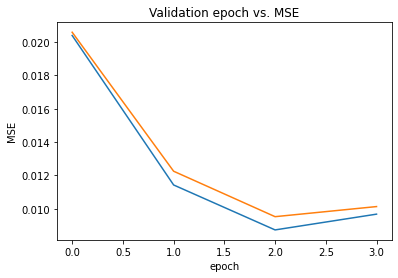

In [4]:
nepochs =  4 
train_metrics = {'mse':[], "rmse":[], 'mse_pi':[], 'rmse_pi':[], 'mse_p':[], 'rmse_p':[] }
vall_metrics = {'mse':[], "rmse":[], 'mse_pi':[], 'rmse_pi':[], 'mse_p':[], 'rmse_p':[] }

for epoch in range(nepochs):  
    '''
    if epoch ==(nepochs-1):
        model.eval()
        outt = []
        for i, data in enumerate(train_loader):
            data = data.to(device) 
            out = model(data.x, data.edge_index, data.batch).to(device)
            out = out.cpu()
            outt+=[[out.detach().numpy()]]
        #print(outt)
        #break'''
    #print("BEFORE TRAIN()")                                                                                                                                                                                                                  
    train()
    #print("BEFORE TEST(TRAIN_LOADER)")                                                                                                                                                                                                       
    #train_mse, train_rmse, train_mse_pi, train_rmse_pi, train_mse_p, train_rmse_p = test(train_loader)
    train_mse = test(train_loader)

    train_metrics['mse'].append(train_mse)
    #train_metrics['rmse'].append(train_rmse)
    #train_metrics['mse_pi'].append(train_mse_pi)
    #train_metrics['rmse_pi'].append(train_rmse_pi)
    #train_metrics['mse_p'].append(train_mse_p)
    #train_metrics['rmse_p'].append(train_rmse_p)

    #print("BEFORE TEST(VAL_LOADER)")                                                                                                                                                                                                         
    #vall_mse, vall_rmse, vall_mse_pi, vall_rmse_pi, vall_mse_p, vall_rmse_p = test(val_loader)
    vall_mse =test(val_loader) 
    #if epoch==0 or val_roc_auc >np.max(val_metrics["roc_auc"]) :                                                                                                                                                                             
    #    model_best_auc = model                                                                                                                                                                                                               
    #    PATH = '/work/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023/model_best_auc.pt'                                                                                                                                                
    #    torch.save({                                                                                                                                                                                                                         
    #        'epoch': epoch,                                                                                                                                                                                                                  
    #        'model_state_dict': model.state_dict(),                                                                                                                                                                                          
    #        'optimizer_state_dict': optimizer.state_dict(),                                                                                                                                                                                  
 #             'loss': loss,                                                                                                                                                                                                                  
    #        }, PATH)                                                                                                                                                                                                                         

    vall_metrics['mse'].append(vall_mse)
    #vall_metrics['rmse'].append(vall_rmse)
    #vall_metrics['mse_pi'].append(vall_mse)
    #vall_metrics['rmse_pi'].append(vall_mse)
    #vall_metrics['mse_p'].append(vall_mse)
    #all_metrics['rmse_p'].append(vall_mse)
    if epoch%9==0:
        print("Epoch ",epoch," Train mse: ",train_mse)
        print("Epoch ",epoch," Validation mse: ",vall_mse)
        #print("Epoch ",epoch," Train mse: ",train_mse," Train rmse: ",train_rmse," Train mse pion: ",train_mse_pi,
         #     " Train rmse pion: ",train_rmse_pi, "Train mse proton:",train_mse_p, "Train rmse proton:",train_rmse_p)
        #print("Epoch ",epoch," Validation mse: ",vall_mse," Validation rmse: ",vall_rmse," Validation mse pion: ",vall_mse_pi,
        #      " Validation rmse pion: ",vall_rmse_pi, "Validation mse proton:",vall_mse_p, "Validation rmse proton:", vall_rmse_p)
    if epoch==(nepochs-1):
        a = print_out()
        print("Epoch ",epoch," Train mse: ",train_mse)
        print("Epoch ",epoch," Validation mse: ",vall_mse)
        #print("Epoch ",epoch," Train mse: ",train_mse," Train rmse: ",train_rmse," Train mse pion: ",train_mse_pi,
        #      " Train rmse pion: ",train_rmse_pi, "Train mse proton:",train_mse_p, "Train rmse proton:",train_rmse_p)
        #print("Epoch ",epoch," Validation mse: ",vall_mse," Validation rmse: ",vall_rmse," Validation mse pion: ",vall_mse_pi,
        #      " Validation rmse pion: ",vall_rmse_pi, "Validation mse proton:",vall_mse_p, "Validation rmse proton:", vall_rmse_p) 

        #print(a)
import matplotlib.pyplot as plt 

epochs = [i for i in range(len(train_metrics["mse"]))]  
plt.figure() 
plt.title('Training epoch vs. MSE') 
plt.plot(epochs, train_metrics['mse']) 
plt.xlabel('epoch')
plt.ylabel('MSE')


plt.title('Validation epoch vs. MSE')   
plt.plot(epochs, vall_metrics['mse']) 
plt.xlabel('epoch') 
plt.ylabel('MSE')  

(-1.0, 5.0)

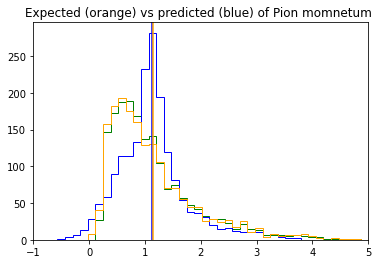

In [5]:
pi_x = []; p_x = [] 
for i in range(len(a)):
    for j in range(len(a[i][0])): 
        pi_x.append(a[i][0][j][0].item())
        #p_x.append(a[i][0][j][1].item()) 

pi_yy = [] 
#p_yy = []

pi_rec_y = []
#p_rec_y = []
for i, data in enumerate(test_loader):
    data = data#.to(device) #put to GPU
    #break
    for j in range(0,int(len(data.y))): 
        pi_yy.append(data.y[j].item())
 #       p_yy.append(data.y[j+1].item())

        #pi_rec_y.append(data.rec[j].item())
       # p_rec_y.append(data.rec[j+1].item())
    for j in range(len(data.rec)):
        #pi_rec_y.append(data.rec[j][0][0])
        pi_rec_y.append(data.rec[j][0])
       # p_rec_y.append(data.rec[j][0][1])


plott_pi = np.zeros((len(pi_x),3))
#plott_p = np.zeros((len(p_x),2))
for i in range(len(pi_x)):
    plott_pi[i][0] = pi_yy[i]
    plott_pi[i][1] = pi_x[i]
   # plott_pi[i][2] = pi_rec_y[i]
   # plott_p[i][0] = p_yy[i]
   # plott_p[i][1] = p_x[i]
    #plott_p[i][2]  = p_rec_y[i]
for i in range(len(pi_rec_y)):
    plott_pi[i][2] = pi_rec_y[i]
#plott_pi 
plt.figure
plt.title('Expected (orange) vs predicted (blue) of Pion momnetum ') 
plt.axvline(x = np.mean(pi_x), color = 'blue')
plt.axvline(x = np.mean(pi_yy), color = 'orange')
plt.hist(x = plott_pi, histtype ='step', color = ['orange', 'blue', 'green'], bins = 100)
plt.xlim((-1,5))
#plt.hist(x = plott_pi, histtype ='bar', color = ['orange', 'blue'], bins = 30)

In [6]:
print(np.mean(pi_yy))
print(np.std(pi_yy))

-2.580327566683238
3.542116569909027


In [6]:
from scipy.stats import kstest   
print(kstest(pi_x, pi_yy)) 
print(kstest(pi_rec_y, pi_yy))   

KstestResult(statistic=0.17797552836484984, pvalue=2.7653250563405137e-25)
KstestResult(statistic=0.02836484983314794, pvalue=0.46470870503833095)


In [10]:
diff_x = []
diff_rec = []
for i in range(len(pi_x)):
    diff_x.append((pi_x[i]-pi_yy[i])**2)
    diff_rec.append((pi_rec_y[i]-pi_yy[i])**2)
print(np.mean(diff_x)) 
print(np.mean(diff_rec))

11.170951681720114
138.3180609566097


KstestResult(statistic=0.1618464961067853, pvalue=5.786770747273661e-21)
KstestResult(statistic=0.02836484983314794, pvalue=0.46470870503833095)
0.29740851413743946
0.11349461194306334


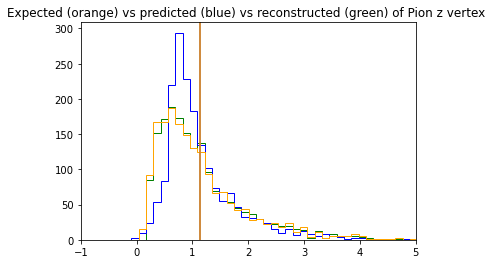

In [8]:
ave =np.zeros(len(pi_x))
for i in range(len(pi_x)): 
    ave[i] = ( pi_x[i]+pi_rec_y[i])/2

plott_pi = np.zeros((len(pi_x),3))
#plott_p = np.zeros((len(p_x),2)) 
for i in range(len(pi_x)):
    plott_pi[i][0] = pi_yy[i]
    plott_pi[i][1] = ave[i]
for i in range(len(pi_rec_y)): 
    plott_pi[i][2] = pi_rec_y[i]
#plott_pi 
plt.figure
plt.title('Expected (orange) vs predicted (blue) vs reconstructed (green) of Pion z vertex ') 
plt.axvline(x = np.mean(pi_x), color = 'blue')
plt.axvline(x = np.mean(pi_yy), color = 'orange')
plt.hist(x = plott_pi, histtype ='step', color = ['orange', 'blue', 'green'], bins = 100)
plt.xlim((-1,5))
#plt.hist(x = plott_pi, histtype ='bar', color = ['orange', 'blue'], bins = 30)

from scipy.stats import kstest   
print(kstest(ave, pi_yy)) 
print(kstest(pi_rec_y, pi_yy)) 

diff_x = []
diff_rec = []
for i in range(len(pi_x)):
    diff_x.append(np.sqrt((ave[i]-pi_yy[i])**2) )
    diff_rec.append(np.sqrt((pi_rec_y[i]-pi_yy[i])**2))
print(np.mean(diff_x))  
print(np.mean(diff_rec))

In [8]:
diff_x = []
diff_rec = []
for i in range(len(pi_x)):
    diff_x.append((pi_x[i]-pi_yy[i])**2)
    diff_rec.append((pi_rec_y[i]-pi_yy[i])**2)
print(np.mean(diff_x)) 
print(np.mean(diff_rec)) 

12.64774916542557
140.2566747478867


KstestResult(statistic=0.2456884561891516, pvalue=0.0)


In [8]:
8.4+2.6


11.0

In [9]:
1.65+2.6


4.25